In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import torch
import os
from collections import deque
import time
import matplotlib.pyplot as plt
import warnings

In [2]:
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=4, linewidth=130)
warnings.filterwarnings("ignore")
model_dir = os.getcwd() + "/model_dir"
os.makedirs(model_dir, exist_ok=True)

In [3]:
# create an envirnment
env = UnityEnvironment(file_name="E:/code/deep-reinforcement-learning/p3_collab-compet/Tennis_Windows_x86_64/Tennis.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)

# size of actions
ACTION_SIZE = brain.vector_action_space_size

# size of the state space
states = env_info.vector_observations
STATE_SIZE = states.shape[1]

print('Num of Agents: {}\nState Shape (per agent): {}\nLength of action space: {}'.format(
       states.shape[0],
       STATE_SIZE,
       ACTION_SIZE))

Num of Agents: 2
State Shape (per agent): 24
Length of action space: 2


In [5]:
def plot(scores):
    '''plot scores'''
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x')
    ax.tick_params(axis='y')
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [16]:
from maddpg_agents import Maddpg
from hyperparameters import *

def train():
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    # create the maddpg agents
    maddpg = Maddpg(STATE_SIZE, ACTION_SIZE, num_agents, SEED)
    # monitor the score
    scores_deque = deque(maxlen=100)
    all_scores = []
    all_avg_score = []
    # initialize OUNoise
    noise = NOISE
    all_steps = 0
    overall_start_time = time.time()
    episodes_start_time = time.time()
    for i_episode in range(N_EPISODES+1):
        env_info = env.reset(train_mode=True)[brain_name]
        maddpg.reset()
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        for steps in range(N_STEPS):
            all_steps += 1
            actions = maddpg.act(states, noise)         # get actions
            noise *= NOISE_REDUCTION                    # decrease action noise
            env_info = env.step(actions)[brain_name]    # send all actions to the environment
            next_states = env_info.vector_observations  # get next state for each agent
            rewards = env_info.rewards                  # get rewards
            dones = env_info.local_done                 # get episode end flags
            maddpg.step(states, actions, rewards, next_states, dones, i_episode)  # save experience and learn
            scores += env_info.rewards
            states = next_states
            if np.any(dones):
                break
                
        # save episode score and compute metrics
        episode_score = np.max(scores) # take the max score of the two agents
        all_scores.append(episode_score)
        scores_deque.append(episode_score)
        avg_score = np.mean(scores_deque)
        
        print('Episode {}\tEpisode score: {:.2f}\tAverage Score: {:.2f}'.format(i_episode, episode_score, avg_score), end="\r")
        if i_episode > 0 and i_episode%100 == 0:
            episodes_run_time = time.time() - episodes_start_time
            episodes_start_time = time.time()
            print('\rEpisode {}\tAverage Score: {:.2f}\tTotal steps: {}\tNoise: {:.2f}\tRuntime: {:.2f} secs'.format(i_episode, avg_score, all_steps, noise, episodes_run_time))
            maddpg.checkpoints()
            all_avg_score.append(avg_score)
            
        # solve
        if i_episode > 99 and avg_score >= 0.5:
            total_run_time = time.time() - overall_start_time
            print('\rEnvironment solved in {} episodes with an Average Score of {:.2f} Total Runtime {:.2f} secs'.format(i_episode, avg_score, total_run_time))
            maddpg.checkpoints()
            return all_scores
        
    return all_scores

Episode 100	Average Score: 0.00	Total steps: 1581	Noise: 0.00	Runtime: 51.55 secs
Episode 200	Average Score: 0.02	Total steps: 3342	Noise: 0.00	Runtime: 73.55 secs
Episode 300	Average Score: 0.03	Total steps: 5304	Noise: 0.00	Runtime: 78.98 secs
Episode 400	Average Score: 0.04	Total steps: 7369	Noise: 0.00	Runtime: 79.28 secs
Episode 500	Average Score: 0.03	Total steps: 9407	Noise: 0.00	Runtime: 77.75 secs
Episode 600	Average Score: 0.03	Total steps: 11440	Noise: 0.00	Runtime: 95.25 secs
Episode 700	Average Score: 0.02	Total steps: 13469	Noise: 0.00	Runtime: 66.83 secs
Episode 800	Average Score: 0.04	Total steps: 16092	Noise: 0.00	Runtime: 89.64 secs
Episode 900	Average Score: 0.05	Total steps: 18946	Noise: 0.00	Runtime: 92.99 secs
Episode 1000	Average Score: 0.07	Total steps: 22259	Noise: 0.00	Runtime: 134.61 secs
Episode 1100	Average Score: 0.08	Total steps: 25441	Noise: 0.00	Runtime: 128.02 secs
Episode 1200	Average Score: 0.10	Total steps: 29169	Noise: 0.00	Runtime: 147.10 secs
Epi

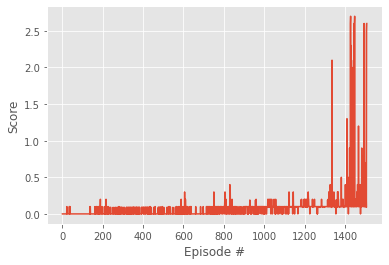

In [17]:
# training
scores = train()
plot(scores)

In [18]:
# check the result
from maddpg_agents import Maddpg
from hyperparameters import *

maddpg_agent = Maddpg(STATE_SIZE, ACTION_SIZE, num_agents, SEED)

In [19]:
maddpg_agent.agents[0].actor_local.load_state_dict(torch.load('./model_dir/checkpoint_actor_local_0.pth'))
maddpg_agent.agents[0].critic_local.load_state_dict(torch.load('./model_dir/checkpoint_critic_local_0.pth'))
maddpg_agent.agents[1].actor_local.load_state_dict(torch.load('./model_dir/checkpoint_actor_local_0.pth'))
maddpg_agent.agents[1].critic_local.load_state_dict(torch.load('./model_dir/checkpoint_critic_local_0.pth'))

In [27]:
env_info = env.reset(train_mode=False)[brain_name]
maddpg_agent.reset()
states = env_info.vector_observations
scores = np.zeros(num_agents)

while True:
    actions = maddpg_agent.act(states, False)
    env_info = env.step(actions)[brain_name]
    rewards = env_info.rewards
    next_states = env_info.vector_observations
    dones = env_info.local_done
    scores += rewards
    states = next_states
    
    if np.any(dones):
        break
        
print('Test Score: {}'.format(np.max(scores)))

Test Score: 1.9000000283122063


In [28]:
env.close()